## The Task

After asking around for the source of the existing data, you learn that the current process is to take a monthly snapshot of prices from a market data provider, which represents the market price of natural gas delivered at the end of each calendar month. This data is available for roughly the next 18 months and is combined with historical prices in a time series database. After gaining access, you are able to download the data in a CSV file.

You should use this monthly snapshot to produce a varying picture of the existing price data, as well as an extrapolation for an extra year, in case the client needs an indicative price for a longer-term storage contract.

- Download the monthly natural gas price data.
- Each point in the data set corresponds to the purchase price of natural gas at the end of a month, from 31st October 2020 to 30th September 2024.
- Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future. 
- Your code should take a date as input and return a price estimate.

Try to visualize the data to find patterns and consider what factors might cause the price of natural gas to vary. This can include looking at months of the year for seasonal trends that affect the prices, but market holidays, weekends, and bank holidays need not be accounted for. Submit your completed code below.

**Note:** This role often requires the knowledge and utilization of data analysis and machine learning. Python is a useful tool and one that JPMorgan Chase uses a lot in quantitative research since it’s capable of completing complex tasks.

Moving forward in this program, the example answers are given in Python code. (If Python is not downloaded on your system, you can execute Python code in Jupyter Notebook online for free.)

# Importing librarires

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

In [3]:
# Load the dataset
data = pd.read_csv('Nat_Gas.csv')
# Display the first few rows of the dataset
data.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [9]:
# describe the dataset
data.describe()

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


In [10]:
# check types of data
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     str    
 1   Prices  48 non-null     float64
dtypes: float64(1), str(1)
memory usage: 900.0 bytes


In [4]:
# check for missing values
data.isnull().sum()

Dates     0
Prices    0
dtype: int64

In [5]:
# check for dubplicate values
data.duplicated().sum()

np.int64(0)

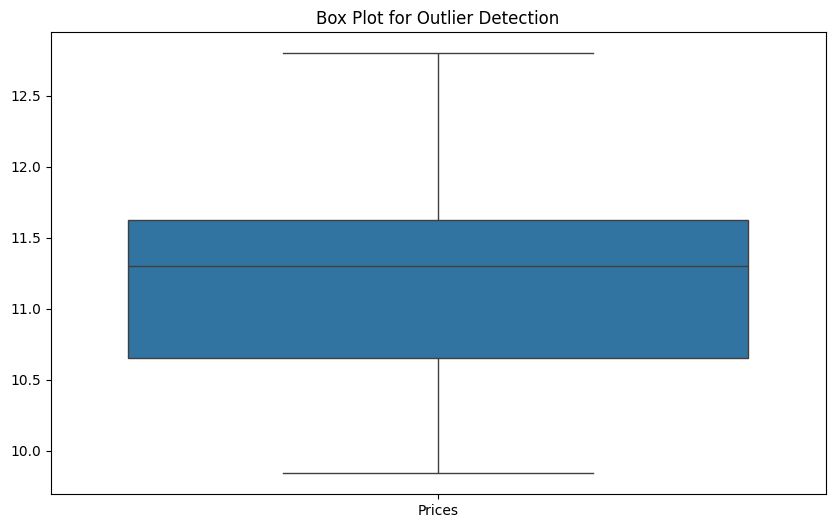

In [6]:
# box plot to check for outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=data)
plt.title('Box Plot for Outlier Detection')
plt.show()

I see that there are no outliers which is good for this

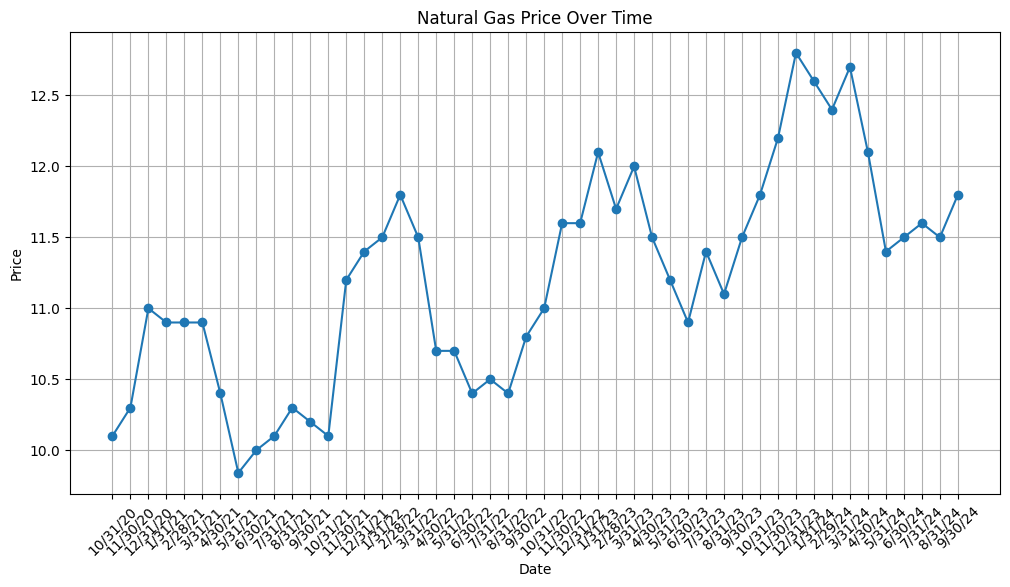

In [8]:
# plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(data['Dates'], data['Prices'], marker='o')
plt.title('Natural Gas Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid()
plt.show()

As expected summers are cheaper than winter.

But I want to take a more granular look and will now divide the data per season and see how seasons affect teh prices

In [ ]:
# Parse the date
data['date_col'] = pd.to_datetime(data['Dates'], format='%m/%d/%y')

# Month name (e.g., "October")
data['Months'] = data['date_col'].dt.month_name()

# Season based on month number
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'
    
# create a new seasson column based on the month number
data['Season'] = data['date_col'].dt.month.map(get_season)

In [15]:
# Sanity check to see the new columns
data.head()

,Dates,Prices,date_col,Months,Season
0,10/31/20,10.1,2020-10-31,October,Fall
1,11/30/20,10.3,2020-11-30,November,Fall
2,12/31/20,11.0,2020-12-31,December,Winter
3,1/31/21,10.9,2021-01-31,January,Winter
4,2/28/21,10.9,2021-02-28,February,Winter


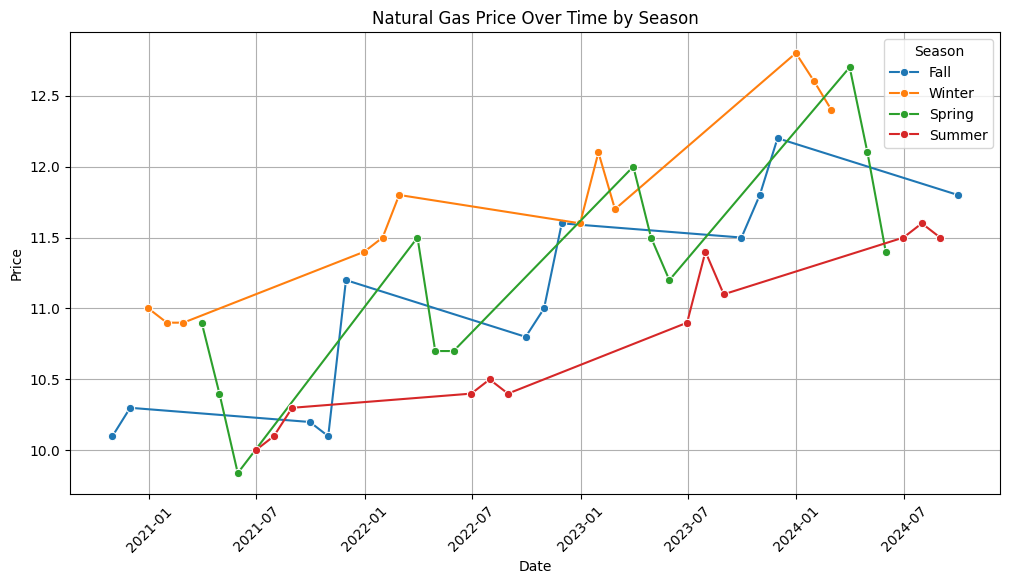

In [14]:
# plot the data by season
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_col', y='Prices', hue='Season', data=data, marker='o')
plt.title('Natural Gas Price Over Time by Season')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid()
plt.legend(title='Season')
plt.show()

As we can see from the plot, there is a clear seasonal pattern in the natural gas prices. The prices tend to be higher during the winter months (December, January, February) and lower during the summer months (June, July, August). This is likely due to increased demand for heating during the winter and decreased demand during the summer. The spring and fall seasons show intermediate price levels.

Yet over all I see a price increase over time, which could be due to various factors such as changes in supply and demand, geopolitical events, or economic conditions. Further analysis would be needed to identify the specific causes of the price trends observed in the data.

# Linear regression

I will first start with linear regression to see if I can captre trends and seasonality with a simple algorithma and check for $R^2$ and will see from there what else I can do

R² score: 0.955


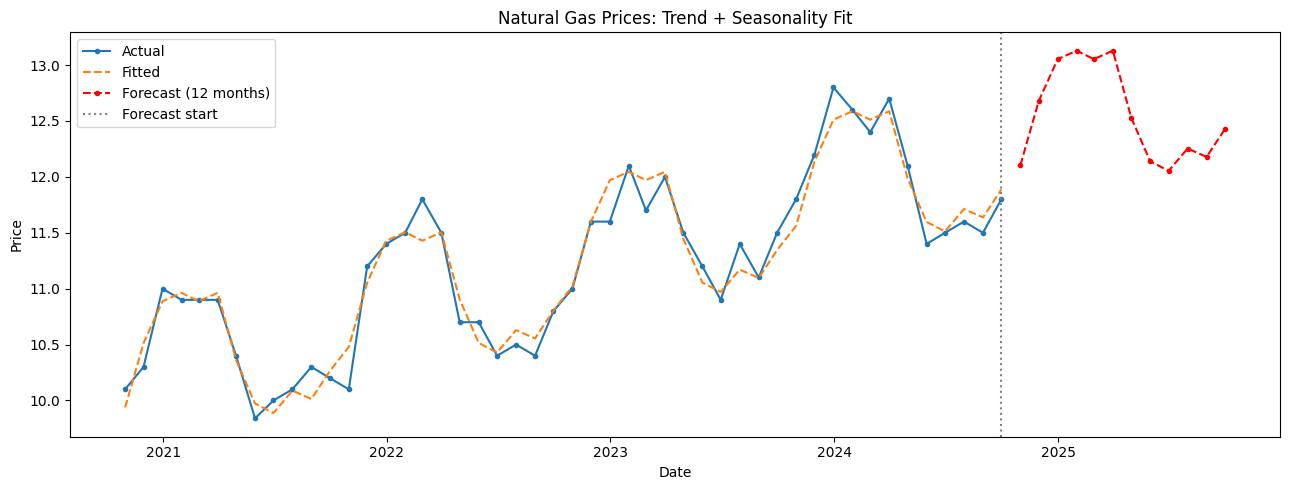

  date_col  predicted_price
2024-10-31         12.10375
2024-11-30         12.67875
2024-12-31         13.05375
2025-01-31         13.12875
2025-02-28         13.05375
2025-03-31         13.12875
2025-04-30         12.52875
2025-05-31         12.13875
2025-06-30         12.05375
2025-07-31         12.25375
2025-08-31         12.17875
2025-09-30         12.42875


In [19]:
# --- Feature Engineering ---
data = data.sort_values('date_col').reset_index(drop=True)
data['time_index'] = np.arange(len(data))

# Month dummies for seasonality
month_dummies = pd.get_dummies(data['Months'], prefix='month', drop_first=True)
data = pd.concat([data, month_dummies], axis=1)

month_cols = [c for c in data.columns if c.startswith('month_')]
X = data[['time_index'] + month_cols]
y = data['Prices']

# --- Fit Model ---
model = LinearRegression()
model.fit(X, y)
data['fitted'] = model.predict(X)

print(f"R² score: {model.score(X, y):.3f}")

# --- Forecast 12 months into the future ---
last_date = data['date_col'].max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='ME')

future_df = pd.DataFrame({'date_col': future_dates})
future_df['time_index'] = np.arange(len(data), len(data) + 12)
future_df['Months'] = future_df['date_col'].dt.month_name()

future_dummies = pd.get_dummies(future_df['Months'], prefix='month')
future_df = pd.concat([future_df, future_dummies], axis=1)

# Ensure same columns as training
for col in month_cols:
    if col not in future_df.columns:
        future_df[col] = 0

future_df['predicted_price'] = model.predict(future_df[['time_index'] + month_cols])

# --- Plot ---
plt.figure(figsize=(13, 5))
plt.plot(data['date_col'], data['Prices'], label='Actual', marker='o', markersize=3)
plt.plot(data['date_col'], data['fitted'], label='Fitted', linestyle='--')
plt.plot(future_df['date_col'], future_df['predicted_price'], label='Forecast (12 months)', linestyle='--', color='red', marker='o', markersize=3)
plt.axvline(x=last_date, color='gray', linestyle=':', label='Forecast start')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices: Trend + Seasonality Fit')
plt.legend()
plt.tight_layout()
plt.show()

# --- View forecast ---
print(future_df[['date_col', 'predicted_price']].to_string(index=False))

In [20]:
# Hold out last 12 months as test set
train = data[data['date_col'] < data['date_col'].max() - pd.DateOffset(months=12)]
test  = data[data['date_col'] >= data['date_col'].max() - pd.DateOffset(months=12)]

X_train = train[['time_index'] + month_cols]
X_test  = test[['time_index'] + month_cols]

model.fit(X_train, train['Prices'])
print(f"Train R²: {model.score(X_train, train['Prices']):.3f}")
print(f"Test  R²: {model.score(X_test,  test['Prices']):.3f}")  # this is what matters

Train R²: 0.936
Test  R²: 0.819


# Residual check

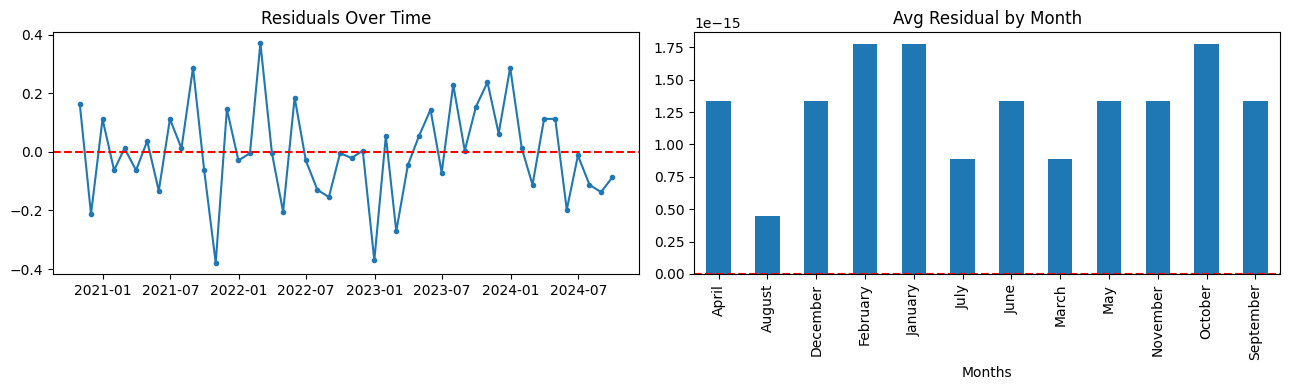

In [21]:
data['residuals'] = data['Prices'] - data['fitted']

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Residuals over time — should look random, no trend
axes[0].plot(data['date_col'], data['residuals'], marker='o', markersize=3)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals Over Time')

# Residuals by month — should be flat, no seasonal pattern left
data.groupby('Months')['residuals'].mean().plot(kind='bar', ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('Avg Residual by Month')

plt.tight_layout()
plt.show()

Residual plot looks healthy, nothing suspicious, the seasonality is captures good as well

# Trying with XGboost regression to see if things work or not.

Train — R²: 0.987 | MAE: 0.052
Val   — R²: -0.228 | MAE: 0.385
Test  — R²: -1.491 | MAE: 0.778


/var/folders/88/t4qwcm1n44z0_870pr_ryj7w0000gn/T/ipykernel_15169/1495131979.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


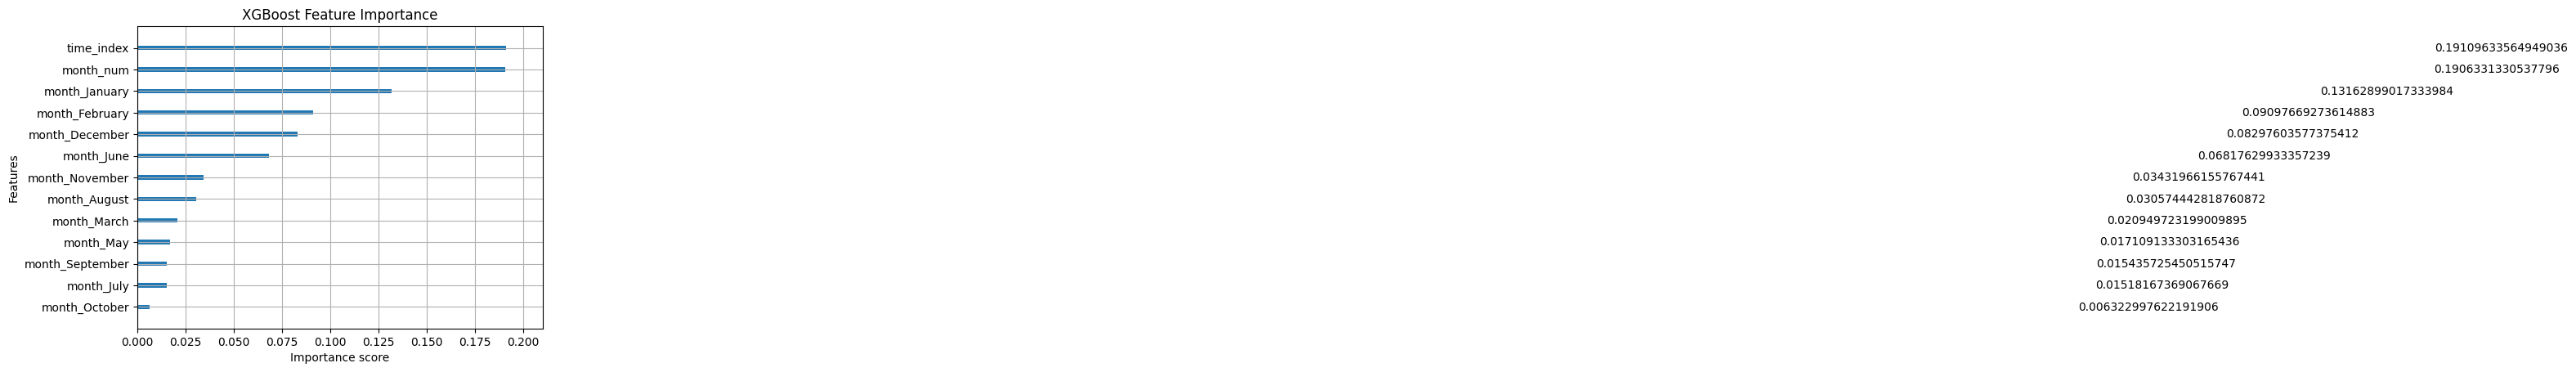

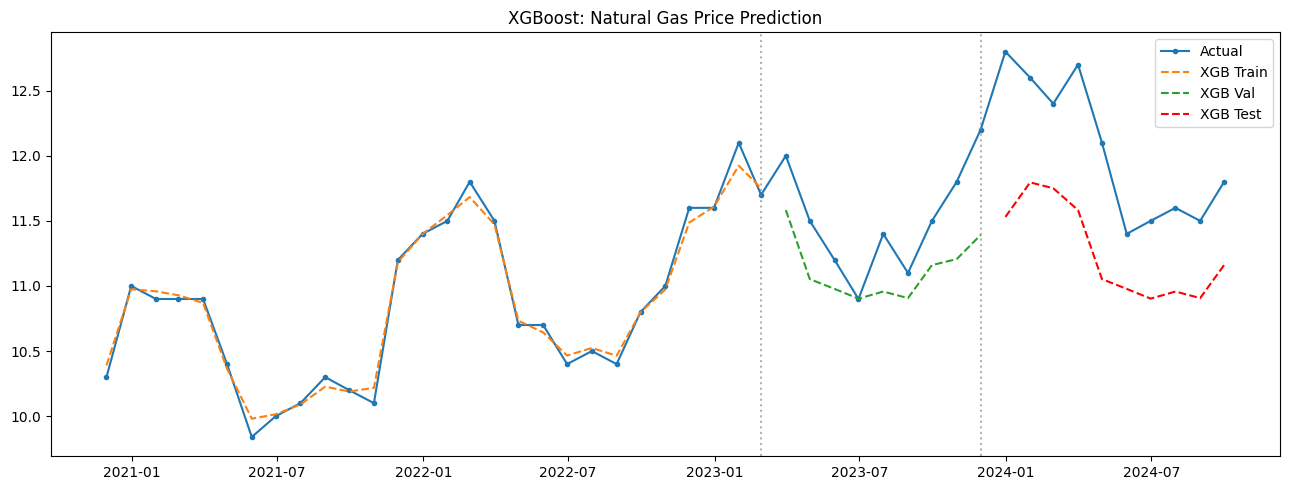

In [24]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error

# --- Features ---
data['time_index'] = np.arange(len(data))

month_dummies = pd.get_dummies(data['Months'], prefix='month', drop_first=True).astype(int)
data = pd.concat([data, month_dummies], axis=1)
data = data.loc[:, ~data.columns.duplicated()]

month_cols = [c for c in data.columns if c.startswith('month_')]
features = ['time_index'] + month_cols

# --- Chronological Split (60 / 20 / 20) ---
n = len(data)
train_end = int(n * 0.60)
val_end   = int(n * 0.80)

train = data.iloc[:train_end]
val   = data.iloc[train_end:val_end]
test  = data.iloc[val_end:]

X_train, y_train = train[features], train['Prices']
X_val,   y_val   = val[features],   val['Prices']
X_test,  y_test  = test[features],  test['Prices']

# --- XGBoost Model ---
model_xgb = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=20,
    random_state=42
)

model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# --- Evaluate ---
for name, X, y in [('Train', X_train, y_train), ('Val', X_val, y_val), ('Test', X_test, y_test)]:
    preds = model_xgb.predict(X)
    print(f"{name:5s} — R²: {r2_score(y, preds):.3f} | MAE: {mean_absolute_error(y, preds):.3f}")

# --- Feature Importance ---
xgb.plot_importance(model_xgb, importance_type='gain')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# --- Plot ---
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(data['date_col'], data['Prices'], label='Actual', marker='o', markersize=3)
ax.plot(train['date_col'], model_xgb.predict(X_train), label='XGB Train', linestyle='--')
ax.plot(val['date_col'],   model_xgb.predict(X_val),   label='XGB Val',   linestyle='--')
ax.plot(test['date_col'],  model_xgb.predict(X_test),  label='XGB Test',  linestyle='--', color='red')
ax.axvline(train['date_col'].max(), color='gray', linestyle=':', alpha=0.6)
ax.axvline(val['date_col'].max(),   color='gray', linestyle=':', alpha=0.6)
ax.set_title('XGBoost: Natural Gas Price Prediction')
ax.legend()
plt.tight_layout()
plt.show()


Train — R²: 0.983 | MAE: 0.062
Val   — R²: 0.292 | MAE: 0.292
Test  — R²: -1.078 | MAE: 0.694


/var/folders/88/t4qwcm1n44z0_870pr_ryj7w0000gn/T/ipykernel_15169/1907593255.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


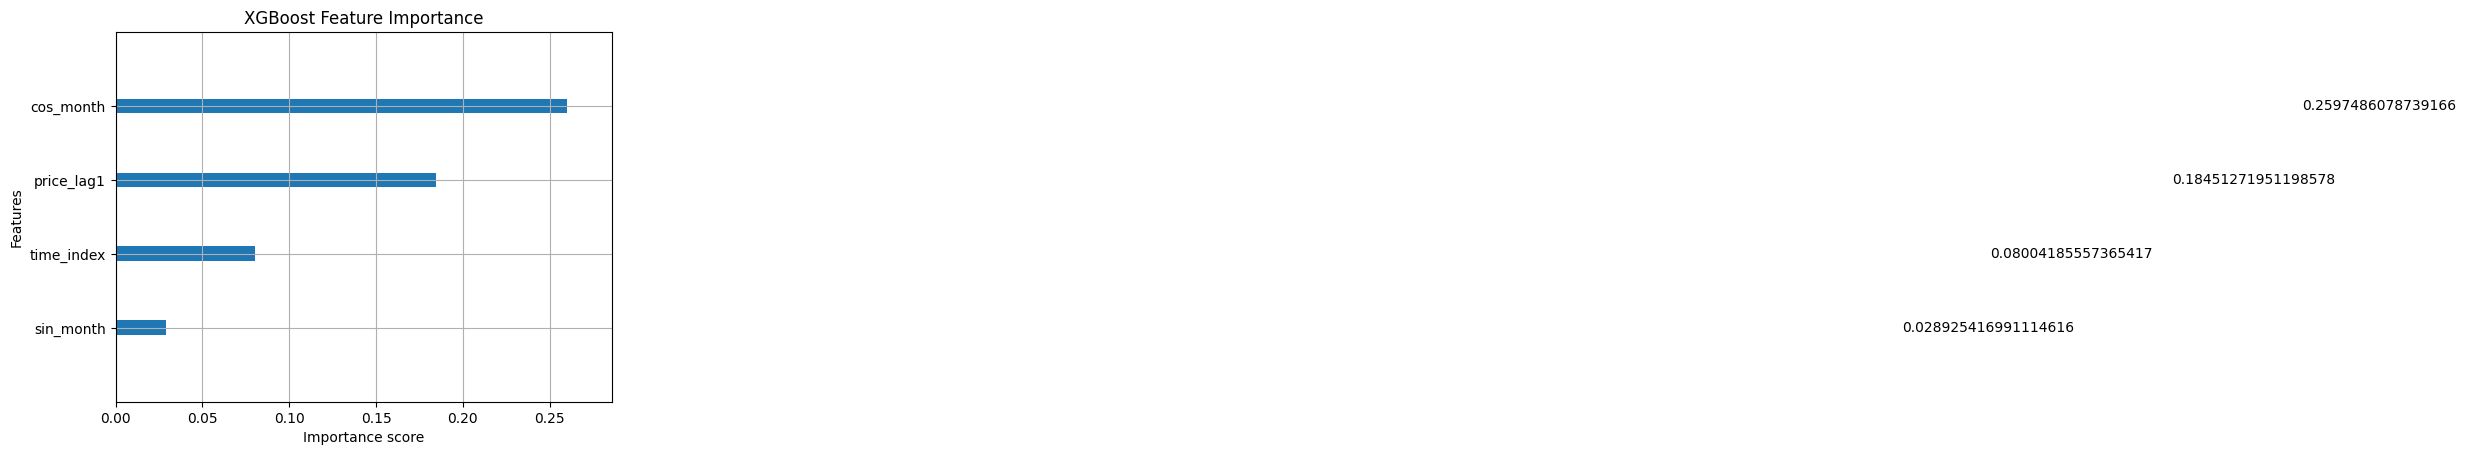

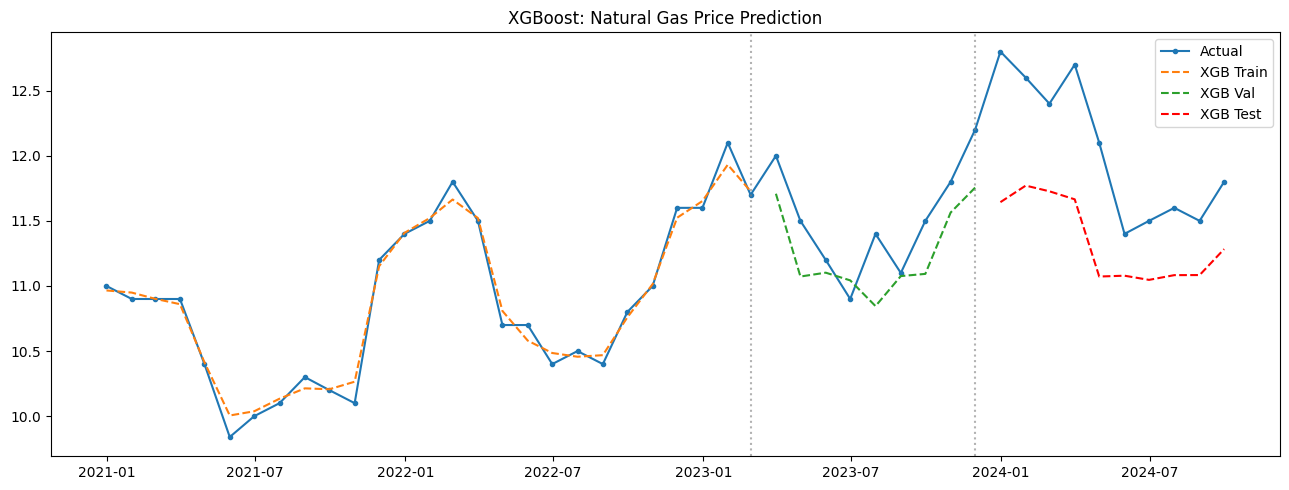

In [26]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error

# --- Features (reuse from before) ---
data['month_num'] = data['date_col'].dt.month
data['sin_month'] = np.sin(2 * np.pi * data['month_num'] / 12)
data['cos_month'] = np.cos(2 * np.pi * data['month_num'] / 12)
data['price_lag1'] = data['Prices'].shift(1)
data = data.dropna().reset_index(drop=True)
data['time_index'] = np.arange(len(data))

features = ['time_index', 'sin_month', 'cos_month', 'price_lag1']

# --- Chronological Split (60 / 20 / 10) ---
n = len(data)
train_end = int(n * 0.60)
val_end   = int(n * 0.80)   # 60% + 20% validation

train = data.iloc[:train_end]
val   = data.iloc[train_end:val_end]
test  = data.iloc[val_end:]

X_train, y_train = train[features], train['Prices']
X_val,   y_val   = val[features],   val['Prices']
X_test,  y_test  = test[features],  test['Prices']

# --- XGBoost Model ---
model_xgb = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=20,
    random_state=42
)

model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# --- Evaluate ---
for name, X, y in [('Train', X_train, y_train), ('Val', X_val, y_val), ('Test', X_test, y_test)]:
    preds = model_xgb.predict(X)
    print(f"{name:5s} — R²: {r2_score(y, preds):.3f} | MAE: {mean_absolute_error(y, preds):.3f}")

# --- Feature Importance ---
xgb.plot_importance(model_xgb, importance_type='gain')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# --- Plot vs Linear Regression ---
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(data['date_col'], data['Prices'], label='Actual', marker='o', markersize=3)
ax.plot(train['date_col'], model_xgb.predict(X_train), label='XGB Train', linestyle='--')
ax.plot(val['date_col'],   model_xgb.predict(X_val),   label='XGB Val',   linestyle='--')
ax.plot(test['date_col'],  model_xgb.predict(X_test),  label='XGB Test',  linestyle='--', color='red')
ax.axvline(train['date_col'].max(), color='gray', linestyle=':', alpha=0.6)
ax.axvline(val['date_col'].max(),   color='gray', linestyle=':', alpha=0.6)
ax.set_title('XGBoost: Natural Gas Price Prediction')
ax.legend()
plt.tight_layout()
plt.show()


I don't see any improvement with feature engineering as well, might want to use SARIMA and ARIMA to chck for time series trends and seasonality

# SARIMA and ARIMA modeling

ADF Statistic: -0.653
p-value: 0.859
Series is NOT stationary (differencing needed)

--- ARIMA(2,1,1) ---
Val  R²: -0.123  | MAE: 0.378
Test R²: -0.453 | MAE: 0.502

--- SARIMA(2,1,1)(1,1,1,12) ---
Val  R²: 0.460  | MAE: 0.235
Test R²: 0.746 | MAE: 0.206


/Users/saroshfarhan/Documents/DataScience/jpmc_data/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/saroshfarhan/Documents/DataScience/jpmc_data/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/saroshfarhan/Documents/DataScience/jpmc_data/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/saroshfarhan/Documents/DataScience/jpmc_data/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)



                                      SARIMAX Results                                      
Dep. Variable:                             Prices   No. Observations:                   27
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  -2.912
Date:                            Sat, 28 Feb 2026   AIC                             17.823
Time:                                    14:09:11   BIC                             21.658
Sample:                                12-31-2020   HQIC                            17.469
                                     - 02-28-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1718      0.689     -0.250      0.803      -1.522       1.178
ar.L2         -0.1936      0.716 

/Users/saroshfarhan/Documents/DataScience/jpmc_data/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/saroshfarhan/Documents/DataScience/jpmc_data/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/saroshfarhan/Documents/DataScience/jpmc_data/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


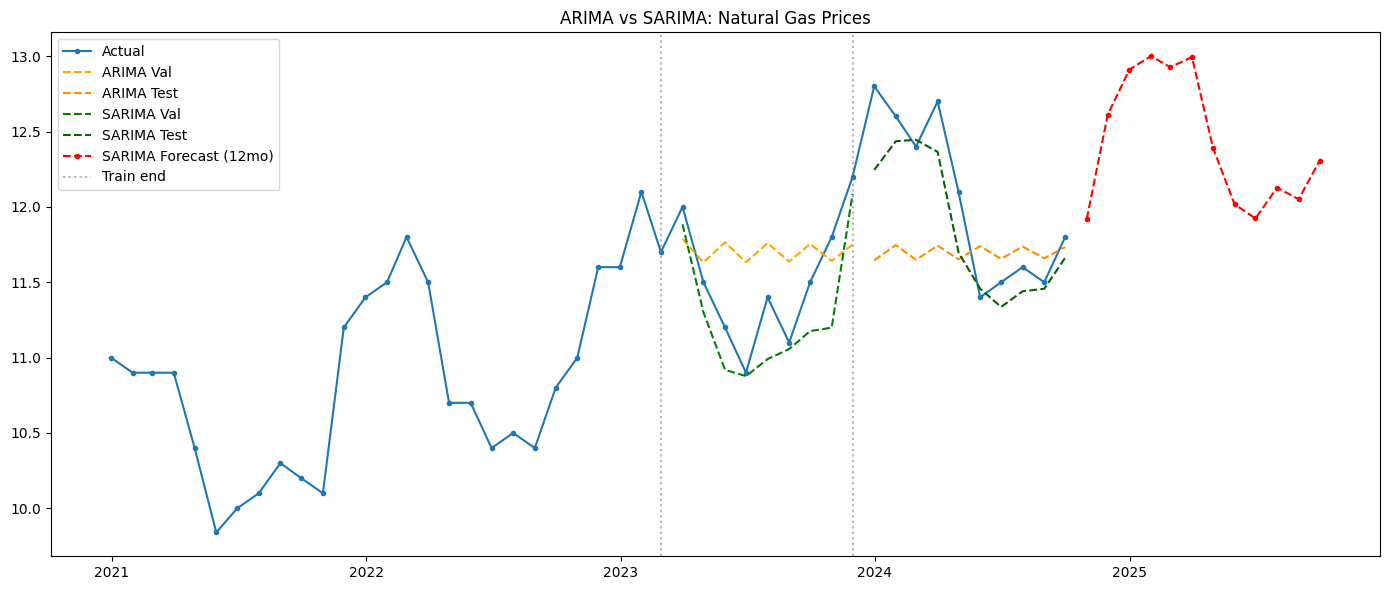

In [27]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, mean_absolute_error

# --- Set date as index ---
ts = data.set_index('date_col')['Prices']

# --- Check Stationarity (ADF Test) ---
result = adfuller(ts)
print(f"ADF Statistic: {result[0]:.3f}")
print(f"p-value: {result[1]:.3f}")
print("Series is", "stationary" if result[1] < 0.05 else "NOT stationary (differencing needed)")

# --- Chronological Split ---
n = len(ts)
train_end = int(n * 0.60)
val_end   = int(n * 0.80)

train_ts = ts.iloc[:train_end]
val_ts   = ts.iloc[train_end:val_end]
test_ts  = ts.iloc[val_end:]

# =====================
# ARIMA (trend only)
# =====================
# (p,d,q): p=2 autoregressive, d=1 differencing for trend, q=1 moving average
arima_model = ARIMA(train_ts, order=(2, 1, 1))
arima_fit   = arima_model.fit()

arima_val_pred  = arima_fit.forecast(steps=len(val_ts))
arima_test_pred = arima_fit.forecast(steps=len(val_ts) + len(test_ts))[len(val_ts):]

print("\n--- ARIMA(2,1,1) ---")
print(f"Val  R²: {r2_score(val_ts,  arima_val_pred):.3f}  | MAE: {mean_absolute_error(val_ts,  arima_val_pred):.3f}")
print(f"Test R²: {r2_score(test_ts, arima_test_pred):.3f} | MAE: {mean_absolute_error(test_ts, arima_test_pred):.3f}")

# =====================
# SARIMA (trend + seasonality)
# =====================
# (p,d,q)(P,D,Q,m): m=12 for monthly seasonality
sarima_model = SARIMAX(train_ts, order=(2, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit   = sarima_model.fit(disp=False)

sarima_val_pred  = sarima_fit.forecast(steps=len(val_ts))
sarima_test_pred = sarima_fit.forecast(steps=len(val_ts) + len(test_ts))[len(val_ts):]

print("\n--- SARIMA(2,1,1)(1,1,1,12) ---")
print(f"Val  R²: {r2_score(val_ts,  sarima_val_pred):.3f}  | MAE: {mean_absolute_error(val_ts,  sarima_val_pred):.3f}")
print(f"Test R²: {r2_score(test_ts, sarima_test_pred):.3f} | MAE: {mean_absolute_error(test_ts, sarima_test_pred):.3f}")

print("\n", sarima_fit.summary())

# =====================
# Forecast 12 months ahead (SARIMA)
# =====================
# Refit on full data for forecasting
sarima_full = SARIMAX(ts, order=(2, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(disp=False)
forecast    = sarima_full.forecast(steps=12)
forecast_dates = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), periods=12, freq='ME')

# =====================
# Plot all models
# =====================
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(ts.index, ts, label='Actual', marker='o', markersize=3)
ax.plot(val_ts.index,  arima_val_pred,   label='ARIMA Val',   linestyle='--', color='orange')
ax.plot(test_ts.index, arima_test_pred,  label='ARIMA Test',  linestyle='--', color='darkorange')
ax.plot(val_ts.index,  sarima_val_pred,  label='SARIMA Val',  linestyle='--', color='green')
ax.plot(test_ts.index, sarima_test_pred, label='SARIMA Test', linestyle='--', color='darkgreen')
ax.plot(forecast_dates, forecast,        label='SARIMA Forecast (12mo)', linestyle='--', color='red', marker='o', markersize=3)
ax.axvline(train_ts.index[-1], color='gray', linestyle=':', alpha=0.6, label='Train end')
ax.axvline(val_ts.index[-1],   color='gray', linestyle=':', alpha=0.6)
ax.set_title('ARIMA vs SARIMA: Natural Gas Prices')
ax.legend()
plt.tight_layout()
plt.show()


In [28]:
# Try simpler seasonal orders - fewer parameters
configs = [
    ((1, 1, 1), (0, 1, 1, 12)),   # remove seasonal AR
    ((0, 1, 1), (0, 1, 1, 12)),   # simplest SARIMA
    ((1, 1, 0), (0, 1, 1, 12)),   # AR only, no MA
    ((2, 1, 1), (0, 1, 1, 12)),   # original but drop seasonal AR
]

print(f"{'Model':<35} {'Val R²':>8} {'Test R²':>8} {'MAE':>8} {'AIC':>8}")
print("-" * 70)

for order, seasonal_order in configs:
    m = SARIMAX(train_ts, order=order, seasonal_order=seasonal_order).fit(disp=False)
    vp = m.forecast(steps=len(val_ts))
    tp = m.forecast(steps=len(val_ts) + len(test_ts))[len(val_ts):]
    label = f"SARIMA{order}{seasonal_order}"
    print(f"{label:<35} {r2_score(val_ts, vp):>8.3f} {r2_score(test_ts, tp):>8.3f} {mean_absolute_error(test_ts, tp):>8.3f} {m.aic:>8.3f}")


Model                                 Val R²  Test R²      MAE      AIC
----------------------------------------------------------------------
SARIMA(1, 1, 1)(0, 1, 1, 12)           0.537    0.780    0.183   14.192


/Users/saroshfarhan/Documents/DataScience/jpmc_data/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/saroshfarhan/Documents/DataScience/jpmc_data/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/saroshfarhan/Documents/DataScience/jpmc_data/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/saroshfarhan/Documents/DataScience/jpmc_data/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)(0, 1, 1, 12)           0.516    0.763    0.190   12.302
SARIMA(1, 1, 0)(0, 1, 1, 12)          -0.201    0.149    0.446   17.073


/Users/saroshfarhan/Documents/DataScience/jpmc_data/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/saroshfarhan/Documents/DataScience/jpmc_data/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/saroshfarhan/Documents/DataScience/jpmc_data/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/saroshfarhan/Documents/DataScience/jpmc_data/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


SARIMA(2, 1, 1)(0, 1, 1, 12)           0.469    0.749    0.196   15.844


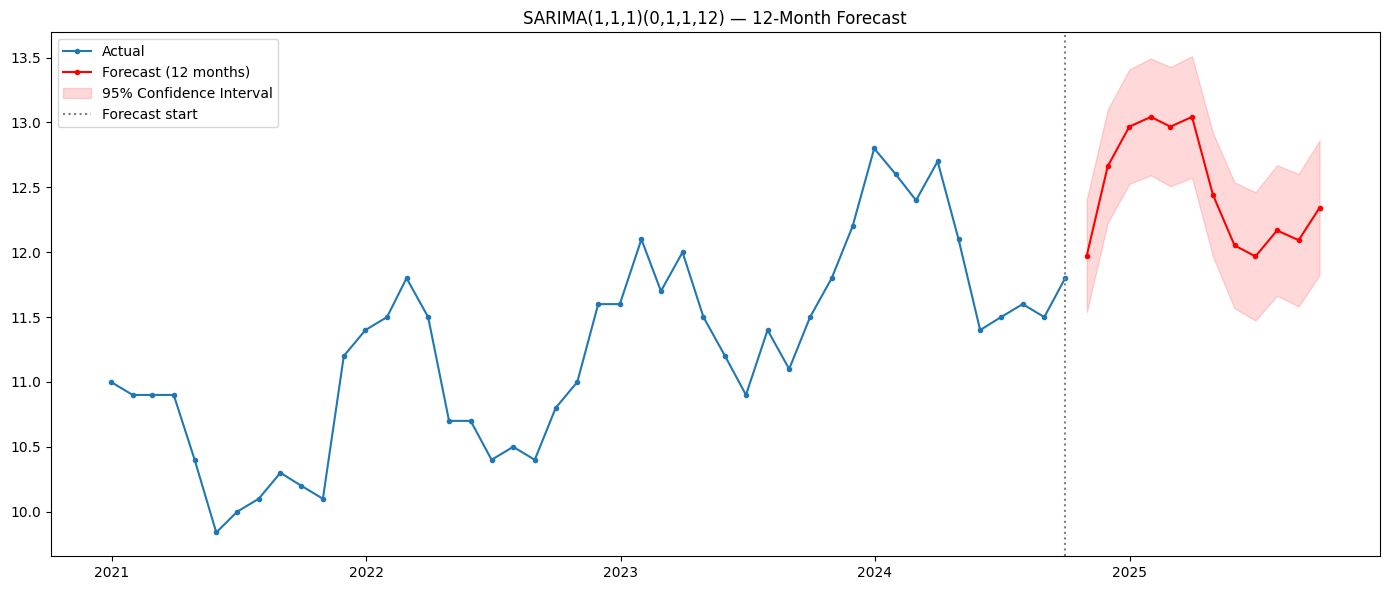

      Date  Forecast Price
2024-10-31          11.974
2024-11-30          12.662
2024-12-31          12.968
2025-01-31          13.043
2025-02-28          12.968
2025-03-31          13.043
2025-04-30          12.443
2025-05-31          12.053
2025-06-30          11.968
2025-07-31          12.168
2025-08-31          12.093
2025-09-30          12.343


In [29]:
# Fix frequency warning + fit best model on full data
ts.index = pd.DatetimeIndex(ts.index, freq='ME')

sarima_best = SARIMAX(ts, order=(1,1,1), seasonal_order=(0,1,1,12)).fit(disp=False)

forecast      = sarima_best.forecast(steps=12)
forecast_ci   = sarima_best.get_forecast(steps=12).conf_int()
forecast_dates = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), periods=12, freq='ME')

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(ts.index, ts, label='Actual', marker='o', markersize=3)
ax.plot(forecast_dates, forecast, label='Forecast (12 months)', color='red', marker='o', markersize=3)
ax.fill_between(forecast_dates, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                color='red', alpha=0.15, label='95% Confidence Interval')
ax.axvline(ts.index[-1], color='gray', linestyle=':', label='Forecast start')
ax.set_title('SARIMA(1,1,1)(0,1,1,12) — 12-Month Forecast')
ax.legend()
plt.tight_layout()
plt.show()

print(pd.DataFrame({'Date': forecast_dates, 'Forecast Price': forecast.round(3)}).to_string(index=False))
